In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import re
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
import imageio
import os
from IPython.display import Image, display
import time
from scipy.stats import gaussian_kde
from statistics import mean
import statistics
import random

In [3]:
plotdir = 'plots/'

In [4]:
Ms = 10 #number of importance samples
CHR = 2
tCutoff = 'None'
samples = range(278*2)
total_loci = 51846
max_allowed_locus = 51398  # Filter threshold
num_ancestor = 1000
ancestor_loci = list(np.linspace(0, total_loci - 1, num=num_ancestor, dtype=int))
ancestor_loci = [locus for locus in ancestor_loci if locus != 0 and locus < max_allowed_locus]

In [5]:
dispersal = np.loadtxt("data/SGDP_contemporary_oldcode_chr2_10M_NoneT.sigma", delimiter=',')
dispersal = dispersal.reshape(2, 2)  # 2×2 covariance matrix
print(dispersal)

[[1.02478649e+00 2.94460751e+00]
 [9.60007145e-02 1.36865202e-03]]


In [6]:
#Loading all the loci to get the mean later
pattern = 'data/SGDP_contemporary_oldcode_chr2_*locus_10M_NoneT_Alls_Allt.locs'

fns = sorted(glob.iglob(pattern))
starts = [int(re.search(r'chr2_(\d+)locus', fn).group(1)) for fn in fns]
locus_order = np.argsort(starts)
fnss_0 = [fns[i] for i in locus_order]


# anc_locs_0 = []
# for i,fns in enumerate(fnss_0):
#     anc_loc = np.loadtxt(fns, delimiter=',')
#     anc_locs_0.append(anc_loc)

# anc_locs_0 = np.array(anc_locs_0)
# anc_locs_0 = np.swapaxes(anc_locs_0,0,1)
# L, n, T, d = anc_locs_0.shape
# L, n, T, d 

anc_locs_0 = []
for i, fpath in enumerate(fnss_0):
    df = pd.read_csv(fpath, header=None, names=["sample", "time", "lat", "lon"])
    samples = sorted(df["sample"].unique())
    timepoints = sorted(df["time"].unique())

    n = len(samples)
    T = len(timepoints)

    if n * T != len(df):
        print(f"Skipping {fpath}: expected {n*T} rows but got {len(df)}")
        continue
    sample_map = {v: i for i, v in enumerate(samples)}
    time_map = {v: i for i, v in enumerate(timepoints)}

    # Map samples and times to indices
    s_idx = df["sample"].map(sample_map).values
    t_idx = df["time"].map(time_map).values

    # Pre-allocate array
    arr = np.full((n, T, 2), np.nan)

    # Fill lat/lon efficiently using broadcasting
    arr[s_idx, t_idx, 0] = df["lon"].values
    arr[s_idx, t_idx, 1] = df["lat"].values

    anc_locs_0.append(arr)

anc_locs_0 = np.array(anc_locs_0)  # shape: (L, n, T, 2)
print("Final shape:", anc_locs_0.shape)

anc_locs = anc_locs_0

L, n, T, d = anc_locs.shape
L, n, T, d

Final shape: (990, 556, 10, 2)


(990, 556, 10, 2)

In [6]:
print(fnss_0[0], fnss_0[1])

data/SGDP_contemporary_oldcode_chr2_51locus_10M_NoneT_Alls_Allt.locs data/SGDP_contemporary_oldcode_chr2_103locus_10M_NoneT_Alls_Allt.locs


In [7]:
ancestor_times = np.logspace(np.log10(4),np.log10(40000),10)
ancestor_times

array([4.00000000e+00, 1.11302376e+01, 3.09705473e+01, 8.61773876e+01,
       2.39793700e+02, 6.67240215e+02, 1.85663553e+03, 5.16619866e+03,
       1.43752547e+04, 4.00000000e+04])

In [8]:
sample_locs = np.loadtxt("data/SGDP_contemporary_only.locations")
sample_locs= sample_locs[:, [1, 0]] #Flip it so it transforms from lat-lon to lon-lat (same format as anc_locs)
print(sample_locs.shape)

(556, 2)


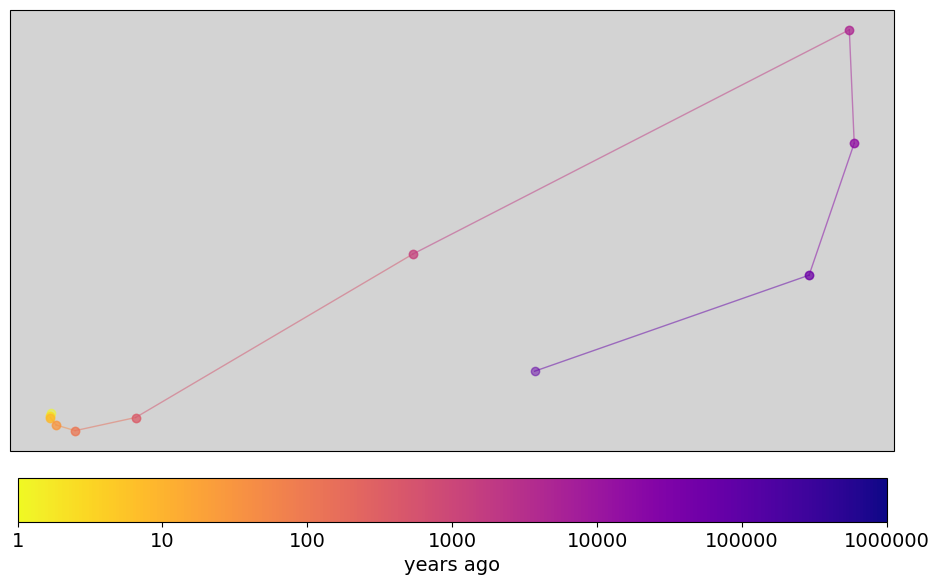

In [37]:
#plotting
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
#ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")

for sample in range(10,11): #samples: #for each sample
    # if (sample % 20 != 0):
    #     continue #Skip by 20 to thin num of samples
    #print(sample, "Population", df_poplabels["pop"][sample], " Group ", df_poplabels["group"][sample])
    # get mean ancestor location at all times
    mean_locs = [sample_locs[sample]]
    # time_loc = locations[sample] #start with sample location
    for time_ix in range(T): #exclude late times as numerical issues
        locs = anc_locs[:,sample,time_ix] #locations of all ancestors
        locs = np.delete(locs, (311), axis=0)
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs.append(mean_loc)
    mean_locs = np.array(mean_locs)


    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs)-1):
        color = cmap(i / len(mean_locs))
        x0,y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1,y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]

        if np.any(np.isnan([x0, y0, x1, y1])):
            continue
        ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic, marker='o') #great circles
        # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4b.png')
plt.show()

311


'data/SGDP_contemporary_oldcode_chr2_16191locus_10M_NoneT_Alls_Allt.locs'

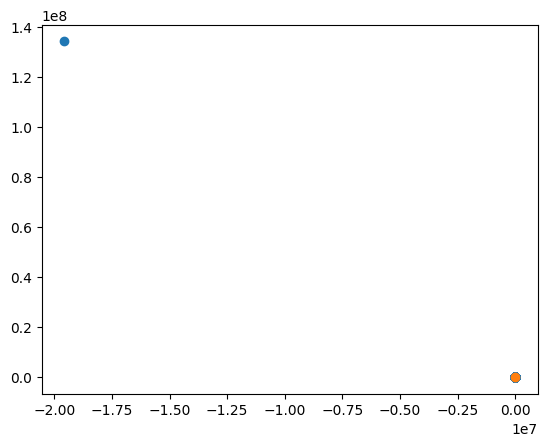

In [42]:
sample_num = 2
x = anc_locs[:, sample_num, 0, 0]
y = anc_locs[:, sample_num, 0, 1]
plt.scatter(x,y)
plt.scatter(sample_locs[sample_num,0], sample_locs[sample_num,1])


for i in range(len(y)):
    if (y[i] > 200):
        print(i)

fnss_0[311]

In [69]:
import spacetrees

stss = np.loadtxt("data/SGDP_contemporary_oldcode_chr2_16191locus_10M.stss")
stss_inv = np.loadtxt("data/SGDP_contemporary_oldcode_chr2_16191locus_10M_NoneT.stss_inv")
locations = np.loadtxt("data/SGDP_contemporary_only.locations")
sigma =  np.loadtxt("data/SGDP_contemporary_oldcode_chr2_10M_NoneT.sigma", delimiter=',')
phi = sigma[-1]
sigma = spacetrees._sds_rho_to_sigma(sigma[:-1])

btss = np.loadtxt("data/SGDP_contemporary_oldcode_chr2_16191locus_10M_NoneT.btss")
lbds = np.array([spacetrees._log_birth_density(bts, sample_times, phi) for bts in btss]) #log probability densities of birth times
log_weights = lbds - lpcs #log importance weights

spacetrees.locate_ancestors([10], [4], stss, stss_inv, locations, 

SyntaxError: incomplete input (551703167.py, line 6)

ValueError: shape mismatch: value array of shape (556,556) could not be broadcast to indexing result of shape (561,)

In [3]:
import numpy as np
from tqdm import tqdm
from spacetrees_old import locate_ancestors, _log_birth_density, _sds_rho_to_sigma 
from utils import chop_shared_times

T = 'None' #get time cutoff
T = None if T=='None' else float(T) #format correctly

stss = np.loadtxt("data/SGDP_contemporary_oldcode_chr2_16191locus_10M.stss", delimiter=',')
k = int((np.sqrt(1+8*len(stss[0])-1)+1)/2) #get size of matrix (from sum_i=0^k i = k(k+1)/2)
stss_mat = [] #list of chopped shared times matrices in matrix form
for sts in stss:
  sts = chop_shared_times(sts, T=T) #chop shared times to ignore history beyond T
  mat = np.zeros((k,k))
  mat[np.triu_indices(k, k=1)] = sts[1:] #convert to numpy matrix
  mat = mat + mat.T + np.diag([sts[0]]*k)      
  stss_mat.append(mat)
stss = stss_mat
# shared times chopped centered inverted
stss_inv = np.loadtxt("data/SGDP_contemporary_oldcode_chr2_16191locus_10M_NoneT.stss_inv", delimiter=',') #list of vectorized chopped centered inverted shared times matrices
k = k-1 #get size of matrix
stss_inv_mat = [] #list of chopped shared times matrices in matrix form
for sts_inv in stss_inv:
  mat = np.zeros((k,k))
  mat[np.triu_indices(k, k=0)] = sts_inv #convert to numpy matrix
  mat = mat + mat.T - np.diag(np.diag(mat))      
  stss_inv_mat.append(mat)
stss_inv = stss_inv_mat
# branching times
btss = []
with open("data/SGDP_contemporary_oldcode_chr2_16191locus_10M_NoneT.btss", 'r') as f:
  for line in f:
    bts = np.fromstring(line, dtype=float, sep=',') #coalescence times in ascending order
    btss.append(bts)
# coal probs
lpcs = np.loadtxt("data/SGDP_contemporary_oldcode_chr2_16191locus_10M_NoneT.lpcs") #log probability of coalescence times
#locations 
locations = np.loadtxt("data/SGDP_contemporary_only.locations") #location of each sample
# dispersal and branching rate
sigma = np.loadtxt("data/SGDP_contemporary_oldcode_chr2_10M_NoneT.sigma", delimiter=',') #mle dispersal rate and branching rate
phi = sigma[-1] #branching rate
sigma = _sds_rho_to_sigma(sigma[:-1]) #dispersal as covariance matrix

# calculate importance weights
lbds = np.array([_log_birth_density(bts, phi, len(locations)) for bts in btss]) #log probability densities of birth times
log_weights = lbds - lpcs #log importance weights

# locate ancestors
# s = 
# if s == 'All': #an option to locate the ancestors of all samples
#   samples = range(k+1)   
# else:
#   samples = [int(s)]
samples = range(11)
t = 4
if t == 'All': #an option to locate at pretermined list of times 
  times = ancestor_times
else: 
  times = [float(t)]
ancestor_locations = locate_ancestors(samples=samples, times=times, 
                                      shared_times_chopped=stss, shared_times_chopped_centered_inverted=stss_inv, locations=locations, 
                                      sigma=sigma, log_weights=log_weights, BLUP=True, BLUP_var=True)



%%%%%%%%%%%% locating ancestors with spacetrees %%%%%%%%%%%%
number of trees per locus: 10 
number of samples: 556 
number of spatial dimensions: 2
samples: range(0, 11) 
times: [4.0]


100%|██████████| 11/11 [00:00<00:00, 177.07it/s]


In [2]:
ancestor_locations


[[0, 4.0, [array([-12.61474298, 142.59721787])], 2935.4458438451065],
 [1, 4.0, [array([-11.97043555, 141.47042944])], 3657.645038477757],
 [2, 4.0, [array([-13.00849637, 142.90852508])], 3712.9513835410935],
 [3, 4.0, [array([-12.73968026, 142.25858613])], 2209.0703603270717],
 [4, 4.0, [array([35.17636911, 25.40017015])], -994.3413556822686],
 [5, 4.0, [array([35.32523835, 24.70785626])], 3599.754275331829],
 [6, 4.0, [array([35.22178085, 25.73825551])], 4624.265556960042],
 [7, 4.0, [array([35.23208825, 25.61304976])], 2296.198329230125],
 [8, 4.0, [array([21.05851186, 99.90527094])], 3423.6353355052597],
 [9, 4.0, [array([21.06756623, 99.90884943])], 3559.737828112442],
 [10, 4.0, [array([ 9.06605952, 23.71680717])], 3581.6175687850186]]

In [12]:
locations[10]

array([ 8.78333333, 27.4       ])

In [27]:
np.mean(anc_locs[:, 10, 0,:], axis=0)

array([ 155195.45563706, -131703.18196988])

In [34]:
mean_locs

array([[27.4       ,  8.78333333],
       [27.39099053,  8.73177509],
       [27.39403019,  8.71351344],
       [27.48152411,  8.6134739 ],
       [27.77617323,  8.53574368],
       [28.71536697,  8.71523466],
       [33.03524967, 10.94481047],
       [39.87923013, 14.00434652],
       [39.92004894, 12.45694769],
       [39.18376038, 10.65691911],
       [34.90641846,  9.34669003]])

In [49]:
stss[0][2]

array([16446.554688, 43898.614416, 44487.452493, 16446.554688,
       16446.554688, 42481.874542, 42015.089844, 16446.554688,
       42773.756317, 42773.756317, 16446.554688, 43373.813408,
       16446.554688, 16446.554688, 16446.554688, 42773.756317,
           0.      , 43583.783131, 16446.554688, 16446.554688,
       16446.554688, 16446.554688, 43644.200987, 42481.874542,
       16446.554688, 42773.756317, 43898.614416, 42015.089844,
       42481.874542, 42773.756317, 42773.756317, 16446.554688,
       16446.554688, 42481.874542, 16446.554688, 16446.554688,
       16446.554688, 42773.756317, 16446.554688, 16446.554688,
       16446.554688, 42481.874542, 16446.554688, 16446.554688,
       42015.089844, 16446.554688, 42773.756317, 43373.813408,
       16446.554688, 16446.554688, 43898.614416, 16446.554688,
       16446.554688, 16446.554688, 43373.813408, 43373.813408,
       42773.756317, 42773.756317, 16446.554688, 42773.756317,
       42015.089844, 43644.200987, 43373.813408, 16446.

In [17]:
arr1 = [0,1]
arr2 = [2]

new = arr1 + arr2
print(new)

[0, 1, 2]
